In [1]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [2]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())
# c:\workspace\autoencoder\02_autoencoder

c:\workspace\autoencoder\02_autoencoder\layer_latent


In [3]:
# 스크립트 실행 경로 변경
# c:\workspace\autoencoder\02_autoencoder 으로 변경
os.chdir('c:/workspace/autoencoder/02_autoencoder')

In [4]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())

c:\workspace\autoencoder\02_autoencoder


In [5]:
########################################################################

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, np.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################

In [6]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               n_mels=128,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # file = SOURCE
    # y, sr = librosa.load(file) # (default  sr=22050)
    # Return
      # y: np.ndarray [shape=(n,) or (…, n)] / audio time series. Multi-channel is supported.
      # sr: number > 0 [scalar / sampling rate of
    # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=(15, 15))
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [7]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge2(SOURCE, TARGET, FIG_SIZE):

    # 01 calculate the number of dimensions
    #dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # STFT -> spectrogram
    hop_length = 512  # in num. of samples
    n_fft = 2048  # window in num. of samples

    # perform stft
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)  # np.abs(stft) ** 2

    # apply logarithm to cast amplitude to Decibels
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=FIG_SIZE)
      plt.axis('off')
      librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [8]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [9]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [10]:
print(tf.__version__)

2.8.0


In [11]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/36cc_out')
print(type(data_dir))
print(data_dir)

<class 'pathlib.WindowsPath'>
dataset\36cc_out


In [12]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

42


In [13]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [14]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [15]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(32, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    mean = np.mean(loss)
    std = np.std(loss)
    threshold = np.mean(loss) + np.std(loss)
    return loss, mean, std, threshold

In [17]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [18]:
'''
2. Load training images
'''
data_path = "./dataset/36cc_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/36cc_out/normal_test"
x_test_normal = create_training_data(data_path)

data_path = "./dataset/36cc_out/abnormal"
x_test_abnormal = create_training_data(data_path)

In [19]:
# '''
# K-fold validation
# '''
# X = x_train
# y = x_train

# k = 4
# num_val_samples = len(X) // k

# num_epochs = 100
# all_scores = []

# for i in range(k):
#     print(f"Processing fold #{i}")
#     val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
#     val_targets = y[i * num_val_samples: (i + 1) * num_val_samples]
#     # i = 0 ==> val_data = X[0:9], val_targets = y[0:9]        
#     # i = 1 ==> val_data = X[9:18], val_targets = y[9:18]     
#     # i = 2 ==> val_data = X[18:27], val_targets = y[18:27]     
#     # i = 3 ==> val_data = X[27:36], val_targets = y[27:36]
#     partial_train_data = np.concatenate(
#         [X[:i * num_val_samples],
#             X[(i + 1) * num_val_samples:]],
#         axis=0)
#     partial_train_targets = np.concatenate(
#         [y[:i * num_val_samples],
#             y[(i + 1) * num_val_samples:]],
#         axis=0)
#     # i = 0 ==> partial_training_data = [X[:0],X[9:]], partial_train_targets = [y[:0],y[9:]]
#     # i = 1 ==> partial_training_data = [X[:9],X[18:]], partial_train_targets = [y[:9],y[18:]]
#     # i = 2 ==> partial_training_data = [X[:18],X[27:]], partial_train_targets = [y[:18],y[27:]]
#     # i = 3 ==> partial_training_data = [X[:27],X[36:]], partial_train_targets = [y[:27],y[36:]]
#     autoencoder = Autoencoder(latent_dim=64 * 4)
#     autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["mae"])
#     hist = autoencoder.fit(partial_train_data, partial_train_targets,
#                             validation_data=(val_data, val_targets),
#                             epochs=num_epochs, batch_size=16, verbose=0)
#     val_mse, val_mae = autoencoder.evaluate(
#         val_data, val_targets, verbose=0)
#     all_scores.append(val_mae)


In [20]:
# # Evaluate all_scores
# all_scores

In [21]:
# np.mean(all_scores)

Processing fold #0
k_train_ds_loss average:  0.0013027447181867375
k_train_ds_Standard deviation:  0.0004789344685229669
k_val_ds_loss average:  0.00576236148002078
k_val_ds_Standard deviation:  0.011293117581575507
k_test_normal_loss average:  0.001554835971084656
k_test_normal_Standard deviation:  0.00043858961570068604
each image loss
0.0015597140433591384 0.0015499578988101732
k_test_abnormal_loss average:  0.004425968092888965
k_test_abnormal_Standard deviation:  0.003181939304211778
each image loss
0.0035269544284935025 0.005324981757284429


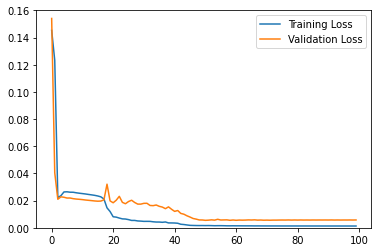

Processing fold #1
k_train_ds_loss average:  0.0012453589905371105
k_train_ds_Standard deviation:  0.0005304947342332452
k_val_ds_loss average:  0.001653591704259306
k_val_ds_Standard deviation:  0.0005585632236281528
k_test_normal_loss average:  0.001541289731920272
k_test_normal_Standard deviation:  0.00044600760770015403
each image loss
0.0015450487406152918 0.001537530723225252
k_test_abnormal_loss average:  0.004991399452861154
k_test_abnormal_Standard deviation:  0.0036839100571861147
each image loss
0.0034903512143512412 0.006492447691371067


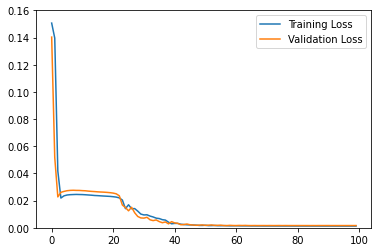

Processing fold #2


ResourceExhaustedError: in user code:

    File "c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ResourceExhaustedError: Exception encountered when calling layer "autoencoder_2" (type Autoencoder).
    
    in user code:
    
        File "C:\Users\astro\AppData\Local\Temp\ipykernel_772\3745963159.py", line 28, in call  *
            encoded = self.encoder(x)
        File "c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\keras\backend.py", line 1920, in random_uniform
            return tf.random.uniform(
    
        ResourceExhaustedError: Exception encountered when calling layer "sequential_4" (type Sequential).
        
        failed to allocate memory [Op:AddV2]
        
        Call arguments received:
          • inputs=tf.Tensor(shape=(None, 224, 224), dtype=float32)
          • training=True
          • mask=None
    
    
    Call arguments received:
      • x=tf.Tensor(shape=(None, 224, 224), dtype=float32)


In [22]:
'''
K-fold validation
'''
X = x_train
y = x_train

k = 4
num_val_samples = len(X) // k

num_epochs = 100
all_scores = []

all_k_train_ds_loss = []
all_k_train_ds_loss_mean = []
all_k_train_ds_std = []
# all_k_train_ds_std_mean = []

all_k_val_ds_loss = []
all_k_val_ds_loss_mean = []
all_k_val_ds_std = []
# all_k_val_ds_std_mean = []

all_k_test_normal_loss = []
all_k_test_normal_loss_mean = []
all_k_test_normal_std = []
# all_k_test_normal_std_mean = []

all_k_test_abnormal_loss = []
all_k_test_abnormal_loss_mean = []
all_k_test_abnormal_std = []
# all_k_test_abnormal_std_mean = []

all_mse_histories = []
all_val_mse_histories = []
all_mae_histories = []
all_std_histories =[]
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [X[:i * num_val_samples],
            X[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y[:i * num_val_samples],
            y[(i + 1) * num_val_samples:]],
        axis=0)
    autoencoder = Autoencoder(latent_dim = 64)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    history = autoencoder.fit(partial_train_data, partial_train_data,
						#shuffle=True,
                        validation_data=(val_data, val_data),
                        epochs=num_epochs, batch_size=16, verbose=0)
    #mae_history = history.history["val_mae"]
    #all_mae_histories.append(mae_history)
    # Fold별 그래프 표시하기 위해 추가함
    # plt.plot(range(1, len(mae_history) + 1), mae_history)
    # plt.xlabel("Epochs")
    # plt.ylabel("Validation MAE")
    # #plt.ylim([0, 0.30])
    # plt.show()

    # '''
    # 4. Set threshold
    # '''


    # def model_threshold(autoencoder, x_train):
    #     encoded_imgs = autoencoder.encoder(x_train).numpy()
    #     decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    #     loss = tf.keras.losses.mse(decoded_imgs, x_train)
    #     mean = np.mean(loss)
    #     std = np.std(loss)
    #     threshold = np.mean(loss) + np.std(loss)
    #     return loss, mean, std, threshold
        
    # k train dataset loss and std
    print("============================")
    k_loss, k_mean, k_std, k_threshold = model_threshold(autoencoder, partial_train_data)    
    all_k_train_ds_loss.append(k_loss)               # k 번째 train dataset의 loss, shape = (27,224) => 쌓기
    all_k_train_ds_loss_mean.append(k_mean)          # k 번째 train dataset의 loss의평균, 단일 값 => 쌓기
    all_k_train_ds_std.append(k_std)                 # k 번째 train dataset의 loss의 Standard deviation , 단일 값 쌓기
    # all_k_train_ds_std_mean.append(np.mean(k_std)) # k 번째 train dataset의 loss의 standard deviation 쌓기
    print("k_train_ds_loss average: ", k_mean)       # k 번째 train dataset의 loss의 평균 => 단일 값
    print("k_train_ds_Standard deviation: ", k_std)  # k 번째 train dataset의 loss의 Standard deviation => 단일 값
   
    # k val datas loss std
    print("============================")
    k_loss, k_mean, k_std, k_threshold = model_threshold(autoencoder, val_data)    
    all_k_val_ds_loss.append(k_loss)               # k 번째 train dataset의 loss, shape = (27,224) => 쌓기
    all_k_val_ds_loss_mean.append(k_mean)          # k 번째 train dataset의 loss의평균, 단일 값 => 쌓기
    all_k_val_ds_std.append(k_std)                 # k 번째 train dataset의 loss의 Standard deviation , 단일 값 쌓기
    # all_k_val_ds_std_mean.append(np.mean(k_std)) # k 번째 train dataset의 loss의 standard deviation 쌓기
    print("k_val_ds_loss average: ", k_mean)       # k 번째 train dataset의 loss의 평균 => 단일 값
    print("k_val_ds_Standard deviation: ", k_std)  # k 번째 train dataset의 loss의 Standard deviation => 단일 값
    
    # k val datas loss std
    print("============================")
    k_loss, k_mean, k_std, k_threshold = model_threshold(autoencoder, x_test_normal)    
    all_k_test_normal_loss.append(k_loss)               # k 번째 train dataset의 loss, shape = (27,224) => 쌓기
    all_k_test_normal_loss_mean.append(k_mean)          # k 번째 train dataset의 loss의평균, 단일 값 => 쌓기
    all_k_test_normal_std.append(k_std)                 # k 번째 train dataset의 loss의 Standard deviation , 단일 값 쌓기
    # all_k_test_normal_std_mean.append(np.mean(k_std)) # k 번째 train dataset의 loss의 standard deviation 쌓기
    print("k_test_normal_loss average: ", k_mean)       # k 번째 train dataset의 loss의 평균 => 단일 값
    print("k_test_normal_Standard deviation: ", k_std)  # k 번째 train dataset의 loss의 Standard deviation => 단일 값
    print("each image loss")
    print(np.mean(k_loss[0]), np.mean(k_loss[1]))
    
    # k val datas loss std
    print("============================")
    k_loss, k_mean, k_std, k_threshold = model_threshold(autoencoder, x_test_abnormal)
    all_k_test_abnormal_loss.append(k_loss)               # k 번째 train dataset의 loss, shape = (27,224) => 쌓기
    all_k_test_abnormal_loss_mean.append(k_mean)          # k 번째 train dataset의 loss의평균, 단일 값 => 쌓기
    all_k_test_abnormal_std.append(k_std)                 # k 번째 train dataset의 loss의 Standard deviation , 단일 값 쌓기
    # all_k_test_abnormal_std_mean.append(np.mean(k_std)) # k 번째 train dataset의 loss의 standard deviation 쌓기
    print("k_test_abnormal_loss average: ", k_mean)       # k 번째 train dataset의 loss의 평균 => 단일 값
    print("k_test_abnormal_Standard deviation: ", k_std)  # k 번째 train dataset의 loss의 Standard deviation => 단일 값
    print("each image loss")
    print(np.mean(k_loss[0]), np.mean(k_loss[1]))

    mse_history = history.history["loss"]
    all_mse_histories.append(mse_history)
    # print("loss average: ", np.mean(mse_history))

    all_std_histories.append(np.std(mse_history))
    # print("Standard deviation: ", np.std(mse_history))

    val_mse_history = history.history["val_loss"]
    all_val_mse_histories.append(val_mse_history)
    # print("val_loss average: ", np.mean(val_mse_history))

    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.ylim([0, 0.16])
    plt.show()


In [ ]:
model_threshold(autoencoder, x_test_normal)[0].shape

TensorShape([2, 224])

In [ ]:
# all_mse_histories

In [ ]:
#생성된 모델을 이용해 all k train dataset의 재구성 오류의 평균 및 std
print("all k train dataset")
print("all k train dataset loss average: ", np.mean(all_k_train_ds_loss))
print("all k train dataset Standard deviation average: ", np.mean(all_k_train_ds_std))
print("all k train dataset threshold average: ", np.mean(all_k_train_ds_loss)+ np.mean(all_k_train_ds_std))

#생성된 모델을 이용해 all k val dataset의 재구성 오류의 평균 및 std
print("all k val dataset")
print("all k val dataset loss average: ", np.mean(all_k_val_ds_loss))
print("all k val dataset Standard deviation average: ", np.mean(all_k_val_ds_std))
print("all k val dataset threshold average: ", np.mean(all_k_val_ds_loss)+ np.mean(all_k_val_ds_std))


all k train dataset
all k train dataset loss average:  0.001262173646104798
all k train dataset Standard deviation average:  0.0005129520055236298
all k train dataset threshold average:  0.0017751256516284279
all k val dataset
all k val dataset loss average:  0.0028023920513745837
all k val dataset Standard deviation average:  0.0036008011632295365
all k val dataset threshold average:  0.006403193214604121


In [ ]:
# Building the history of successive mean K-fold validation scores
average_mse_history = [
    np.mean([x[i] for x in all_mse_histories]) for i in range(num_epochs)]
average_val_mse_history = [
    np.mean([x[i] for x in all_val_mse_histories]) for i in range(num_epochs)]    

In [ ]:
print(max(average_mse_history))
print(min(average_mse_history))

0.1487215906381607
0.0012683466484304518


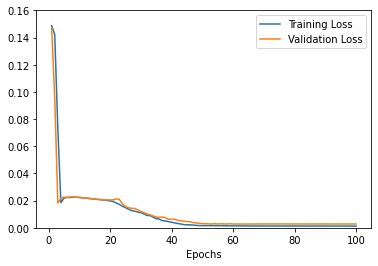

In [ ]:
# Plotting validation scores
plt.plot(range(1, len(average_mse_history) + 1), average_mse_history, label="Training Loss")
plt.plot(range(1, len(average_val_mse_history) + 1), average_val_mse_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()
plt.ylim([0, 0.16])
plt.show()

In [ ]:
all_mse_histories = []

In [ ]:
# 모델이 훈련되었으므로 테스트 세트에서 이미지를 인코딩 및 디코딩하여 테스트해 보겠습니다.
encoded_imgs = autoencoder.encoder(x_test_abnormal).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# x_train
# x_test_normal
# x_test_abnormal

In [ ]:
np.mean(tf.keras.losses.mse(x_test_normal[0], decoded_imgs[0]))

0.0033243387

In [ ]:
# n = 3
# plt.figure(figsize=(20, 10))
# for i in range(n):
#   # display original
#   ax = plt.subplot(2, n, i + 1)
#   plt.imshow(x_train[i])
#   plt.title("original")
#   plt.gray()
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)

#   # display reconstruction
#   ax = plt.subplot(2, n, i + 1 + n)
#   plt.imshow(decoded_imgs[i])
#   plt.title("reconstructed")
#   plt.gray()
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)
# plt.show()

In [ ]:
autoencoder.summary

<bound method Model.summary of <__main__.Autoencoder object at 0x000002228E4C9B20>>